<!--
 * @Author: Wenyu Ouyang
 * @Date: 2022-11-10 10:13:24
 * @LastEditTime: 2022-11-10 10:16:12
 * @LastEditors: Wenyu Ouyang
 * @Description: 
 * @FilePath: /HydroSPB/hydroSPB/app/multi_task/water_balance.ipynb
 * Copyright (c) 2021-2022 Wenyu Ouyang. All rights reserved.
-->
# 长期水量平衡分析

把每个流域的多年平均径流、蒸散发和降雨都取出来，先把观测值取出来，画图看看。降雨是只有观测的，径流和蒸散发多任务和单任务学习模型下分别还有一套预测值。

## 读取591个站点的观测数据

In [2]:
import os
import sys
from pathlib import Path

sys.path.append(os.path.dirname(Path(os.path.abspath('')).parent.parent))
import definitions
from hydroSPB.data.source.data_camels import Camels
from hydroSPB.data.source_pro.data_camels_pro import CamelsPro

Please Check your directory:
ROOT_DIR of the repo:  /mnt/data/owen411/code/HydroSPB
DATA_SOURCE_DIR of the repo:  /mnt/data/owen411/data


/mnt/data/owen411/program/miniconda3/envs/HydroSPB22/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import pandas as pd

这591个站点的编号：

In [4]:
camels591_file="../../example/camels/camels_us_mtl_2001_2021_flow_screen.csv"
# if false, run camels_multioutput_preprocess.py in this directory
os.path.isfile(camels591_file)

True

In [5]:
camels591_ids = pd.read_csv(camels591_file,dtype={'GAGE_ID':str})['GAGE_ID'].values
camels591_ids[:5]

array(['01013500', '01022500', '01030500', '01031500', '01047000'],
      dtype=object)

In [6]:
# 选取数据的时间段
# time_range = ["2001-10-01", "2021-10-01"]
time_range = ["2016-10-01", "2021-10-01"]

降雨数据是NLDAS的，所以读取NLDAS的降雨数据，用NLDAS CAMELS

In [7]:
source_path=[
            os.path.join(definitions.DATASET_DIR, "camelsflowet"),
            os.path.join(definitions.DATASET_DIR, "modiset4camels"),
            os.path.join(definitions.DATASET_DIR, "camels", "camels_us"),
            os.path.join(definitions.DATASET_DIR, "nldas4camels"),
            os.path.join(definitions.DATASET_DIR, "smap4camels"),
        ]
camels_pro = CamelsPro(source_path)

In [8]:
# precipitation from NLDAS 2
pet_prcps = camels_pro.read_relevant_cols(object_ids=camels591_ids, t_range_list=time_range,relevant_cols=["potential_evaporation", "total_precipitation"], forcing_type="nldas")

Read NLDAS forcing data for CAMELS-US: 100%|██████████| 591/591 [00:16<00:00, 34.87it/s]


pet和prcp的单位都是kg/m^2/day，用水的1000kg/m^3密度换算就是mm/day

In [9]:
pet = pet_prcps.mean(axis=1)[:, 0]
pet.shape

(591,)

In [10]:
p = pet_prcps.mean(axis=1)[:, 1]
p.shape

(591,)

In [11]:
flow_ets = camels_pro.read_target_cols(object_ids=camels591_ids, t_range_list=time_range,target_cols=["usgsFlow", "ET"])

Read MODIS ET data for CAMELS-US: 100%|██████████| 591/591 [00:04<00:00, 132.24it/s]


flow的单位是ft^3/s，需要用流域面积换算成mm/day；

ET的单位是0.1kg/m^2/8day，读取的时候已经计算到日平均了，所以是0.1kg/m^2/day，用水的1000kg/m^3密度换算也是0.1mm/day，
并且已经在读取的时候额外补充了乘以0.1，转变为mm/day了，因此也不必再转换了。

In [12]:
# 转换径流单位需要有流域面积
basin_areas = camels_pro.read_basin_area(object_ids=camels591_ids)

In [13]:
# 先转立方米每秒
flows = flow_ets[:, :, 0] / 35.314666721489
# 再用面积转成mm/day
flows = flows / basin_areas * 1e3 / 1e6 * 86400
flows.shape

(591, 1826)

In [14]:
q = np.nanmean(flows, axis=1)
q.shape

(591,)

In [15]:
ets = flow_ets[:, :, 1]

In [16]:
et = np.nanmean(ets,axis=1)
et.shape

(591,)

## 读取预测数据

把多任务Q-ET的结果和单任务Q或ET的预测结果数据读取出来。

现在只有5年的数据，所以就先用这五年的数据

In [17]:
mtl_q_et_valid_exps = ["exp41031", "exp41025", "exp41019", "exp41013"]
mtl_q_et_test_exps = [tmp + "0" for tmp in mtl_q_et_valid_exps]
# for streamflow single task learning model, I put test case in 410010
stl_q_valid_exps = ["exp41001"]
stl_q_test_exps = ["exp410010"]
stl_et_valid_exps = ["exp42001"]
# for et single task learning model, valid and test exps are same
stl_et_test_exps = ["exp42001"]

In [18]:
exps_q_et_valid = stl_q_valid_exps + mtl_q_et_valid_exps
exps_q_et_test = stl_q_test_exps + mtl_q_et_test_exps
exps_et_q_valid = stl_et_valid_exps + mtl_q_et_valid_exps
exps_et_q_test = stl_et_test_exps + mtl_q_et_test_exps

In [19]:
from hydroSPB.app.multi_task.mtl_results_utils import read_multi_single_exps_results

In [20]:
exps_q_et_results_valid, q_et_best_index_valid = read_multi_single_exps_results(
    exps_q_et_valid, ensemble=-1
)
exps_q_et_results, _, preds_q, obss_q = read_multi_single_exps_results(
    exps_q_et_test, q_et_best_index_valid, ensemble=-1, return_value=True
)

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


In [21]:
mtl_q_is_better = np.where(exps_q_et_results[0] < exps_q_et_results[-1])
mtl_q_is_better[0].shape

(408,)

In [22]:
stl_q_is_better = np.where(exps_q_et_results[0] > exps_q_et_results[-1])
stl_q_is_better[0].shape

(183,)

In [23]:
# 验证下抽取出来的best结果计算NSE和抽取的最优NSE是否一致
from hydroSPB.utils.hydro_stat import statError
inds_q_ = statError(obss_q[0], preds_q[-1])
np.median(inds_q_["NSE"]) == np.median(exps_q_et_results[-1])

divide by zero encountered in double_scalars


True

In [24]:
q_mtl_best = preds_q[-1]
q_mtl = q_mtl_best.mean(axis=1)
q_mtl.shape

(591,)

读取此时（best for q）多任务的蒸发结果

In [25]:
# et when best4q
exps_et_q_results, _, preds_et, obss_et = read_multi_single_exps_results(
    exps_et_q_test,
    q_et_best_index_valid,
    var_idx=1,
    single_is_flow=False,
    flow_idx_in_mtl=0,
    ensemble=-1,
    return_value=True
)

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


In [26]:
mtl_et_is_better = np.where(exps_et_q_results[0] < exps_et_q_results[-1])
mtl_et_is_better[0].shape

(578,)

In [27]:
stl_et_is_better = np.where(exps_et_q_results[0] > exps_et_q_results[-1])
stl_et_is_better[0].shape

(13,)

In [28]:
# 检查ET的结果对不对
inds_et_ = statError(obss_et[0], preds_et[-1], fill_nan="mean")
np.median(inds_et_["NSE"]) == np.median(exps_et_q_results[-1])


True

In [29]:
et_mtl_best = preds_et[-1]
# because et's unit is 0.1mm/day so we multiply et with 0.1 to transform unit to mm/day 
# old version of ET has unit of 0.1mm/day
et_mtl = et_mtl_best.mean(axis=1) * 0.1
et_mtl.shape

(591,)

下面读取的是单任务Q的预测结果

In [30]:
q_stl = preds_q[0].mean(axis=1)
et_stl = preds_et[0].mean(axis=1) * 0.1

mtl ET和Q预测NSE都更高的站点编号

In [31]:
mtl_better_basins_idxs = np.intersect1d(mtl_q_is_better[0], mtl_et_is_better[0])
mtl_better_basins_idxs.shape

(401,)

In [32]:
other_basins_idxs = np.setdiff1d(np.arange(len(camels591_ids)), mtl_better_basins_idxs)
other_basins_idxs.shape

(190,)

## 水量平衡相关绘图

多画几种图，看看他们分别是怎么回事。

1. P-Q 和 ET 的带1:1关系线的散点图
2. ET/P（evaporative coefficient蒸散发系数）和PET/P（aridity index干旱指数）的散点图以及Budyko曲线
3. Q/P（runoff coefficient径流系数）和PET/P（aridity index干旱指数）的散点图以及1:1关系线 

P/PET是humidity index湿润指数，和干旱指数互为倒数，表达的意思类似。

先把这些数据计算出来，然后是绘图

In [33]:
p_minus_q = p - q
runoff_coef = q / p
humidity_index = p / pet
evap_coef = et / p
aridity_index = pet / p

### P-Q和ET

首先绘制P-Q和ET的散点图，看看他们的关系

把多任务预测较好和单任务预测较好的点区分开，把预测NSE用颜色区分出来，看看他们的分布

In [34]:
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

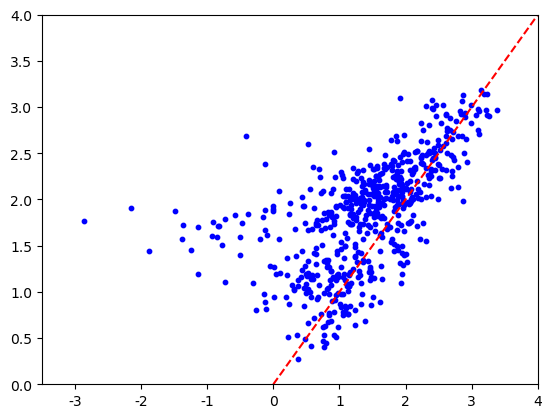

In [35]:
fig, ax = plt.subplots()
ax.scatter(p_minus_q, et, c="blue", s=10)
xlim = [-3.5, 4]
ylim = [0, 4]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
line = mlines.Line2D([0, 4], [0, 4], color="red", linestyle="--")
ax.add_line(line)

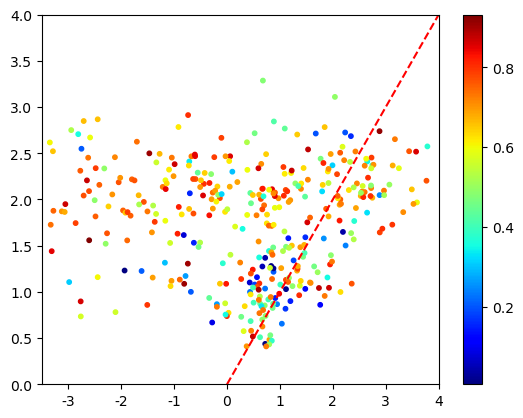

In [36]:
fig, ax = plt.subplots()
show_nse = np.where(exps_q_et_results[0]>0)
plt.scatter((p - q_stl)[show_nse], et_stl[show_nse], c=exps_q_et_results[0][show_nse], cmap="jet", s=10)
# show_nse = np.where(exps_et_q_results[0]>0)
# plt.scatter((p - q_stl)[show_nse], et_stl[show_nse], c=exps_et_q_results[0][show_nse], cmap="jet", s=10)

plt.colorbar()
# ax.scatter((p - q_stl)[mtl_better_basins_idxs], et_stl[mtl_better_basins_idxs], c="blue", s=10)
# ax.scatter((p - q_stl)[other_basins_idxs], et_stl[other_basins_idxs], c="grey", s=10)
xlim = [-3.5, 4]
ylim = [0, 4]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
line = mlines.Line2D([0, 4], [0, 4], color="red", linestyle="--")
ax.add_line(line)

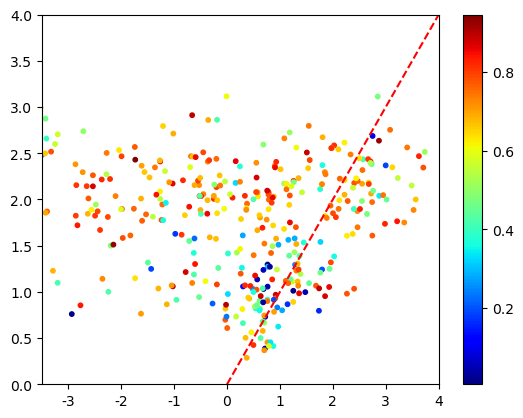

In [37]:
fig, ax = plt.subplots()
# ax.scatter(p - q_mtl, et_mtl, s=10)
show_nse = np.where(exps_q_et_results[-1]>0)
plt.scatter((p - q_mtl)[show_nse], et_mtl[show_nse], c=exps_q_et_results[-1][show_nse], cmap="jet", s=10)
# show_nse = np.where(exps_et_q_results[0]>0)
# plt.scatter((p - q_mtl)[show_nse], et_mtl[show_nse], c=exps_et_q_results[-1][show_nse], cmap="jet", s=10)
plt.colorbar()
# ax.scatter((p - q_mtl)[mtl_better_basins_idxs], et_mtl[mtl_better_basins_idxs], c="blue", s=10)
# ax.scatter((p - q_mtl)[other_basins_idxs], et_mtl[other_basins_idxs], c="grey", s=10)
xlim = [-3.5, 4]
ylim = [0, 4]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
line = mlines.Line2D([0, 4], [0, 4], color="red", linestyle="--")
ax.add_line(line)

### ET/P 和 PET/P

先画观测的ET/P和PET/P的散点图，把Budyko曲线也画出来，纵坐标是ET/P，横坐标是PET/P

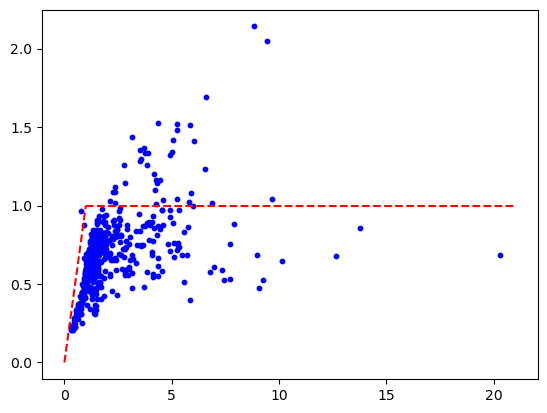

In [38]:
fig, ax = plt.subplots()
ax.scatter(pet/p, et/p, c="blue", s=10)
# ax.scatter(p_minus_q[mtl_better_basins_idxs], et[mtl_better_basins_idxs], c="blue", s=10)
# ax.scatter(p_minus_q[other_basins_idxs], et[other_basins_idxs], c="grey", s=10)
energy_limit_line = mlines.Line2D([0, 1], [0, 1], color="red", linestyle="--")
water_limit_line = mlines.Line2D([1, 21], [1, 1], color="red", linestyle="--")
ax.add_line(energy_limit_line)
ax.add_line(water_limit_line)

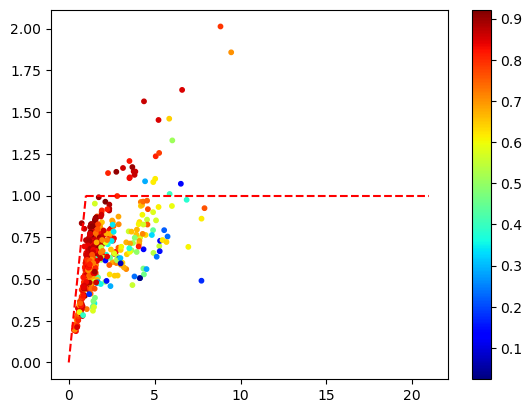

In [39]:
fig, ax = plt.subplots()
show_nse = np.where(exps_et_q_results[0]>0)
plt.scatter(pet[show_nse]/p[show_nse], et_stl[show_nse]/p[show_nse], c=exps_et_q_results[0][show_nse],cmap="jet", s=10)
plt.colorbar()
energy_limit_line = mlines.Line2D([0, 1], [0, 1], color="red", linestyle="--")
water_limit_line = mlines.Line2D([1, 21], [1, 1], color="red", linestyle="--")
ax.add_line(energy_limit_line)
ax.add_line(water_limit_line)

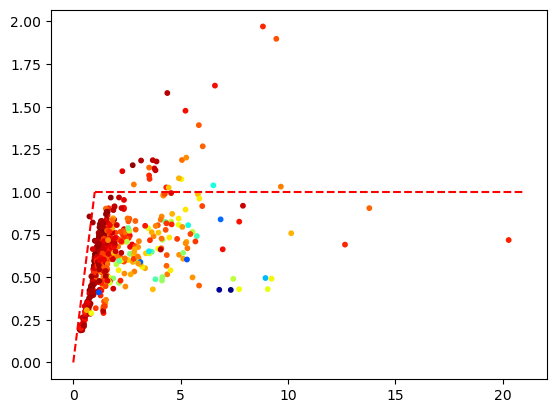

In [40]:
fig, ax = plt.subplots()
show_nse = np.where(exps_et_q_results[-1]>0)
plt.scatter(pet[show_nse]/p[show_nse], et_mtl[show_nse]/p[show_nse], c=exps_et_q_results[-1][show_nse],cmap="jet", s=10)
# ax.scatter(pet/p, et_mtl/p, c="blue", s=10)
# ax.scatter(p_minus_q[mtl_better_basins_idxs], et[mtl_better_basins_idxs], c="blue", s=10)
# ax.scatter(p_minus_q[other_basins_idxs], et[other_basins_idxs], c="grey", s=10)
energy_limit_line = mlines.Line2D([0, 1], [0, 1], color="red", linestyle="--")
water_limit_line = mlines.Line2D([1, 21], [1, 1], color="red", linestyle="--")
ax.add_line(energy_limit_line)
ax.add_line(water_limit_line)

把ET的预测提升特别明显的点取出来

In [41]:
np.where(exps_et_q_results[-1] - exps_et_q_results[0]>0)[0].shape

(578,)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdaec82e2f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdaec82e890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdaec82e020>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdaec82ee30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdaec82f100>],
 'means': []}

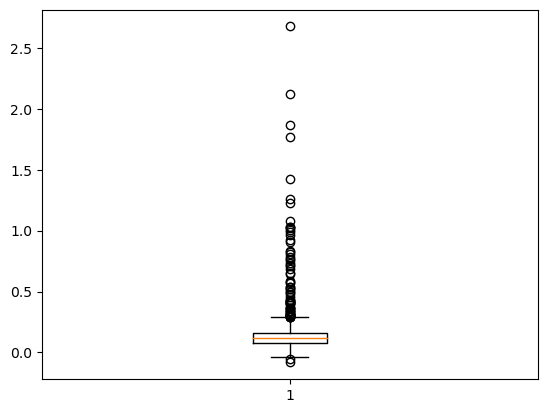

In [42]:
plt.boxplot(exps_et_q_results[-1] - exps_et_q_results[0])

### Q/P和PET/P

Budyko曲线主要还是讨论ET，现在看看Q

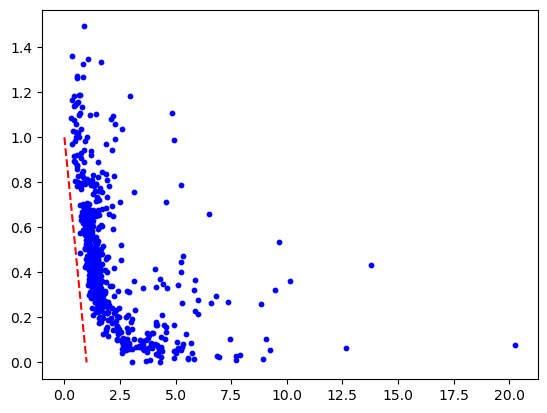

In [43]:
fig, ax = plt.subplots()
ax.scatter(pet/p, q/p, c="blue", s=10)
limit_line = mlines.Line2D([0, 1], [1, 0], color="red", linestyle="--")
ax.add_line(limit_line)
# ax.scatter(p_minus_q[mtl_better_basins_idxs], et[mtl_better_basins_idxs], c="blue", s=10)
# ax.scatter(p_minus_q[other_basins_idxs], et[other_basins_idxs], c="grey", s=10)

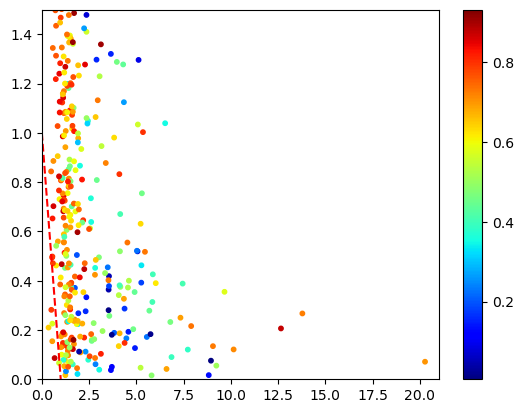

In [44]:
fig, ax = plt.subplots()
show_nse = np.where(exps_q_et_results[0]>0)
plt.scatter(pet[show_nse]/p[show_nse], q_stl[show_nse]/p[show_nse], c=exps_q_et_results[0][show_nse],cmap="jet", s=10)
plt.colorbar()
xlim = [0, 21]
ylim = [0, 1.5]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
limit_line = mlines.Line2D([0, 1], [1, 0], color="red", linestyle="--")
ax.add_line(limit_line)

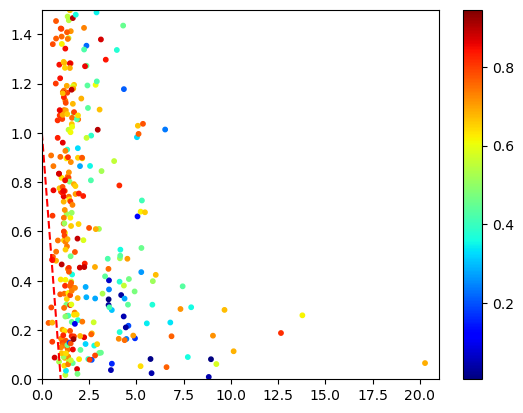

In [45]:
fig, ax = plt.subplots()
show_nse = np.where(exps_q_et_results[-1]>0)
plt.scatter(pet[show_nse]/p[show_nse], q_mtl[show_nse]/p[show_nse], c=exps_q_et_results[-1][show_nse],cmap="jet", s=10)
plt.colorbar()
xlim = [0, 21]
ylim = [0, 1.5]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
limit_line = mlines.Line2D([0, 1], [1, 0], color="red", linestyle="--")
ax.add_line(limit_line)

把Q预测提升明显的点找出来

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdaec6a54b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdaec6a5a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdaec6a5300>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdaec6a5ff0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdaec6a62c0>],
 'means': []}

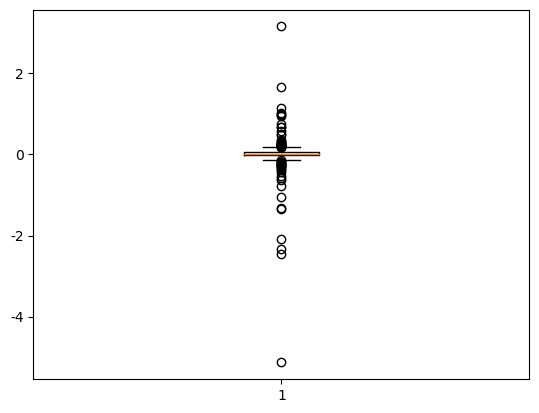

In [46]:
plt.boxplot(exps_q_et_results[-1] - exps_q_et_results[0])

## 提升明显和不明显的两组观测水量平衡比较

整体看，差别不是太明显，趋势上整体都是一致的，把有改善的和没改善的点画出来看看它们的水量平衡有没有什么系统性差别

In [47]:
q_improve = exps_q_et_results[-1] - exps_q_et_results[0]
et_improve = exps_et_q_results[-1] - exps_et_q_results[0]
q_mtl_better = np.where(q_improve>np.median(q_improve))
et_mtl_better = np.where(et_improve>np.median(et_improve))
q_stl_better = np.where(q_improve<=np.median(q_improve))
et_stl_better = np.where(et_improve<=np.median(et_improve))
both_better_idx = np.intersect1d(q_mtl_better, et_mtl_better)
q_nse_over_0 = np.where(exps_q_et_results[0]>0)
et_nse_over_0 = np.where(exps_et_q_results[0]>0)
both_nse_over_0 = np.intersect1d(q_nse_over_0, et_nse_over_0)
both_better_idx_and_nse_over_0 = np.intersect1d(both_better_idx, both_nse_over_0)

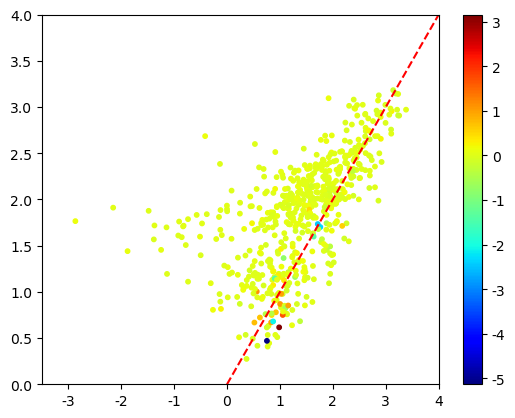

In [48]:
fig, ax = plt.subplots()
# ax.scatter(p - q_mtl, et_mtl, s=10)
# plt.scatter((p - q_mtl)[both_better_idx_and_nse_over_0], et_stl[both_better_idx_and_nse_over_0], c=q_improve[both_better_idx_and_nse_over_0], cmap="jet", s=10)
# plt.scatter((p - q)[both_better_idx_and_nse_over_0], et[both_better_idx_and_nse_over_0], c=q_improve[both_better_idx_and_nse_over_0], cmap="jet", s=10)
plt.scatter(p - q, et, c=q_improve, cmap="jet", s=10)
plt.colorbar()
xlim = [-3.5, 4]
ylim = [0, 4]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
line = mlines.Line2D([0, 4], [0, 4], color="red", linestyle="--")
ax.add_line(line)

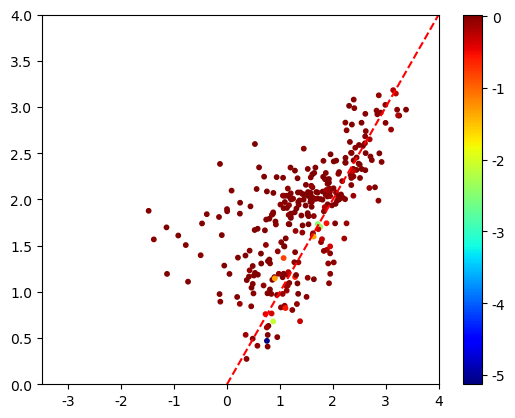

In [49]:
fig, ax = plt.subplots()
plt.scatter((p - q)[q_stl_better], et[q_stl_better], c=q_improve[q_stl_better], cmap="jet", s=10)
# plt.scatter((p - q)[et_stl_better], et[et_stl_better], c=et_improve[et_stl_better], cmap="jet", s=10)
plt.colorbar()
xlim = [-3.5, 4]
ylim = [0, 4]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
line = mlines.Line2D([0, 4], [0, 4], color="red", linestyle="--")
ax.add_line(line)

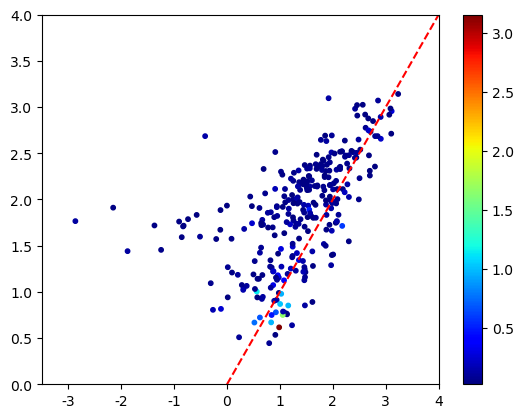

In [50]:
fig, ax = plt.subplots()
plt.scatter((p - q)[q_mtl_better], et[q_mtl_better], c=q_improve[q_mtl_better], cmap="jet", s=10)
# plt.scatter((p - q)[et_mtl_better], et[et_mtl_better], c=et_improve[et_mtl_better], cmap="jet", s=10)
plt.colorbar()
xlim = [-3.5, 4]
ylim = [0, 4]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
line = mlines.Line2D([0, 4], [0, 4], color="red", linestyle="--")
ax.add_line(line)

蒸发小，不平衡的流域更容易提升

再来看看蒸发提升明显的流域是不是就是干旱的流域

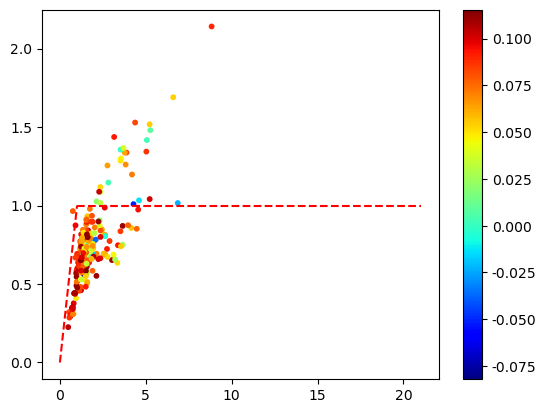

In [51]:
fig, ax = plt.subplots()
plt.scatter(pet[et_stl_better]/p[et_stl_better], et[et_stl_better]/p[et_stl_better], c=et_improve[et_stl_better],cmap="jet", s=10)
plt.colorbar()
energy_limit_line = mlines.Line2D([0, 1], [0, 1], color="red", linestyle="--")
water_limit_line = mlines.Line2D([1, 21], [1, 1], color="red", linestyle="--")
ax.add_line(energy_limit_line)
ax.add_line(water_limit_line)
# xlim = [0, 4]
# ylim = [0, 1.2]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

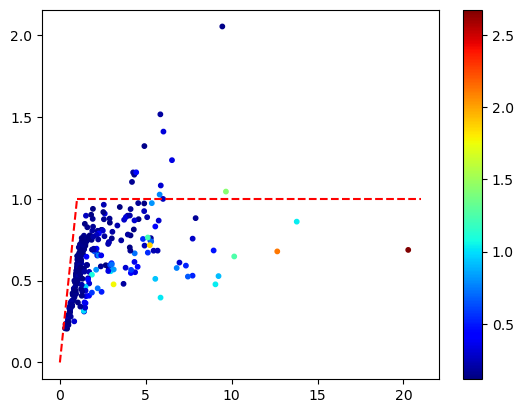

In [52]:
fig, ax = plt.subplots()
plt.scatter(pet[et_mtl_better]/p[et_mtl_better], et[et_mtl_better]/p[et_mtl_better], c=et_improve[et_mtl_better],cmap="jet", s=10)
plt.colorbar()
# ax.scatter(pet/p, et_mtl/p, c="blue", s=10)
# ax.scatter(p_minus_q[mtl_better_basins_idxs], et[mtl_better_basins_idxs], c="blue", s=10)
# ax.scatter(p_minus_q[other_basins_idxs], et[other_basins_idxs], c="grey", s=10)
energy_limit_line = mlines.Line2D([0, 1], [0, 1], color="red", linestyle="--")
water_limit_line = mlines.Line2D([1, 21], [1, 1], color="red", linestyle="--")
ax.add_line(energy_limit_line)
ax.add_line(water_limit_line)
# xlim = [0, 4]
# ylim = [0, 1.2]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

好像确实是干旱的流域更容易改善其蒸散发预测，接下来看看径流这里还有没有规律

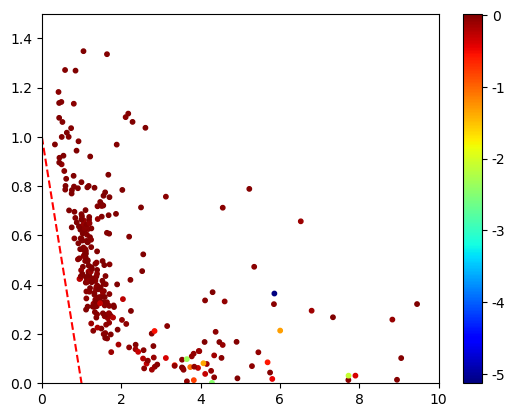

In [53]:
fig, ax = plt.subplots()
plt.scatter(pet[q_stl_better]/p[q_stl_better], q[q_stl_better]/p[q_stl_better], c=q_improve[q_stl_better],cmap="jet", s=10)
plt.colorbar()
xlim = [0, 10]
ylim = [0, 1.5]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
limit_line = mlines.Line2D([0, 1], [1, 0], color="red", linestyle="--")
ax.add_line(limit_line)

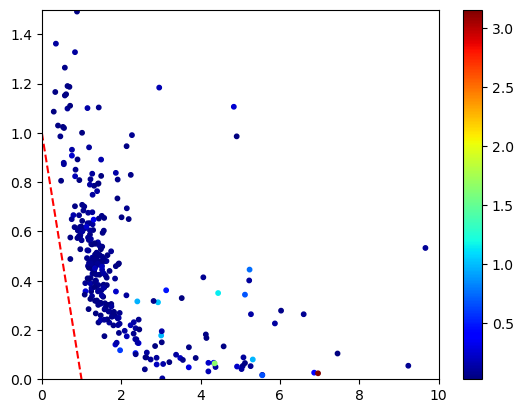

In [54]:
fig, ax = plt.subplots()
plt.scatter(pet[q_mtl_better]/p[q_mtl_better], q[q_mtl_better]/p[q_mtl_better], c=q_improve[q_mtl_better],cmap="jet", s=10)
plt.colorbar()
xlim = [0, 10]
ylim = [0, 1.5]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
limit_line = mlines.Line2D([0, 1], [1, 0], color="red", linestyle="--")
ax.add_line(limit_line)

好像也没有明显的规律

## 看几个提升均非常明显的点

分部分的看过了规律，接下来看细节点，看几个都有提升的点有什么变化

In [94]:
q_improve = exps_q_et_results[-1] - exps_q_et_results[0]
et_improve = exps_et_q_results[-1] - exps_et_q_results[0]
q_mtl_better_75 = np.where(q_improve>0)
et_mtl_better_75 = np.where(et_improve>0.1)
both_better_75_idx = np.intersect1d(q_mtl_better_75, et_mtl_better_75)
q_nse_over_05 = np.where(exps_q_et_results[1]>0)
et_nse_over_05 = np.where(exps_et_q_results[1]>0.5)
both_nse_over_05 = np.intersect1d(q_nse_over_05, et_nse_over_05)
both_better_idx_and_nse_over_05 = np.intersect1d(both_better_75_idx, both_nse_over_05)

In [95]:
np.percentile(q_improve,90)

0.11878672317112637

In [96]:
both_better_idx_and_nse_over_05.shape

(224,)

先画一下地图，然后看看点都在哪

In [97]:
lat_lon = camels_pro.read_constant_cols(
    camels591_ids, ["gauge_lat", "gauge_lon"]
)
lat_lon.shape


(591, 2)

In [98]:
from hydroSPB.visual.plot_stat import plot_boxs, plot_ts, plot_map_carto

<GeoAxesSubplot:>

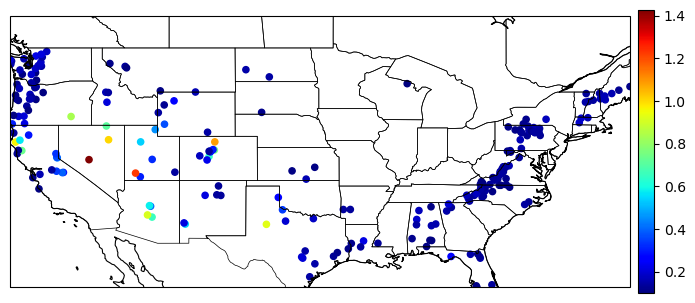

In [99]:
plot_map_carto(
        et_improve[both_better_idx_and_nse_over_05],
        lat=lat_lon[both_better_idx_and_nse_over_05, 0],
        lon=lat_lon[both_better_idx_and_nse_over_05, 1],
        # pertile_range=[0, 100],
        # value_range=[0, 1],
        # idx_lst=idx_lst_plot_final,
        # category_names=category_names,
        # markers=markers,
        # marker_size=10,
        legend_font_size=10,
    )

In [61]:
lat_lon[both_better_idx_and_nse_over_05]

array([[  45.50097,  -68.30596],
       [  45.17501,  -69.3147 ],
       [  44.64275,  -70.58878],
       [  44.30399,  -70.53968],
       [  44.26867,  -71.63036],
       [  44.09284,  -72.33565],
       [  42.63842,  -72.72509],
       [  42.23731,  -72.89565],
       [  41.79091,  -77.01469],
       [  41.57895,  -78.29251],
       [  41.4134 ,  -78.19695],
       [  41.47368,  -77.23081],
       [  41.41841,  -77.03275],
       [  38.33763,  -79.24004],
       [  39.08122,  -78.32945],
       [  38.2454 ,  -79.76866],
       [  37.8029 ,  -80.047  ],
       [  37.72901,  -80.04228],
       [  38.1954 ,  -79.57032],
       [  37.7918 ,  -79.75949],
       [  37.50624,  -80.10671],
       [  37.66596,  -79.91144],
       [  36.56819,  -79.98726],
       [  36.61958,  -79.50419],
       [  36.39778,  -79.19667],
       [  35.06417,  -77.46139],
       [  36.07139,  -81.40306],
       [  36.00056,  -80.74556],
       [  35.83361,  -81.71194],
       [  35.59069,  -81.56704],
       [  

<GeoAxesSubplot:>

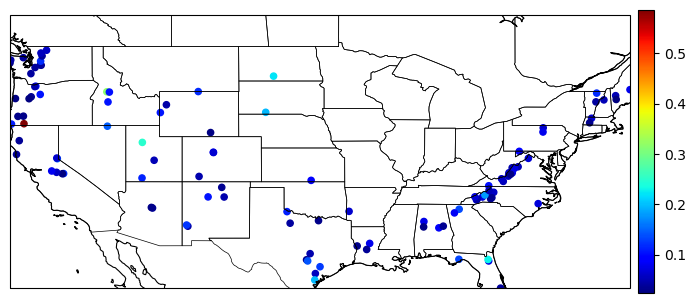

In [62]:
plot_map_carto(
        q_improve[both_better_idx_and_nse_over_0],
        lat=lat_lon[both_better_idx_and_nse_over_0, 0],
        lon=lat_lon[both_better_idx_and_nse_over_0, 1],
        # pertile_range=[0, 100],
        # value_range=[0, 1],
        # idx_lst=idx_lst_plot_final,
        # category_names=category_names,
        # markers=markers,
        # marker_size=10,
        legend_font_size=10,
    )